# Modeling Herd Immunity in Populations

This notebook uses a very simple model for demonstrating the effects of herd immunity and the importance of vaccinations in a population. 

In this notebook, a population is initially constructed of n individuals. Each individual is connected to a random selection of at least a and at most b nearest neighbors.  

Next, some percent of individuals are immunized, some number of individuals are initialized as sick, and some number of individuals who are particularly susceptible to the disease.

Finally, the model takes in parameters on how easily the disease spreads (IllPercent), how likely a sick individual will recover (RecPercent), the effectiveness of the vaccine (vacEffectiveness), the change the disease will cause death in the general population(DeathRate), and the chance the disease will cause death in the particularly susceptible pupation (criticalRate).

After all these parameters are set, the model runs through updates, where any individual connected to a sick individual has a chance of becoming ill and every sick individual has a chance of dying. These can be treated like time steps, and can be used to show how the disease spreads (or doesn't) through the community.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib.patches import Arc
from matplotlib import collections  as mc
import time
from IPython import display

In [2]:
#initial set up of the community
def initNRandConn(n, a, b,):
    Data=pd.DataFrame({"person":list(range(n))}) #use a Pandas dataframe to easily store and quickly access status of each person.
    #randomly chosing locations of individuals on an X-Y plot for visualization purposes:
    x=random.sample(range(1,10*n),n);
    x=np.array(x);
    x.sort();
    Data['X']=x;
    y=np.array([random.randrange(1,int(10*n),1) for _ in range (n)]);
    Data['Y']=y;

    for x in range(0,n):
        Data[str(x)]=0
    #forming random connections between nearest neighbors (hard to do efficiently!)
    for x in range(0,n-1):
        Data.iloc[x,3:3+n]=(((Data.loc[x,'X']-Data.loc[:,'X'])**2+(Data.loc[x,'Y']-Data.loc[:,'Y'])**2)**(1/2)).values;
        num_connections=random.randint(a,b)
        temp=Data.iloc[x,3:3+n].sort_values().index[0:num_connections].values;
        temp=[3+int(i) for i in temp];
        Data.iloc[x,3:3+n]=0
        Data.iloc[x,temp]=1
    #making DataFrame into a connected table of all individuals
    for x in range(0,n):
        Data.iloc[:,3+x]=Data.iloc[x,3:3+n].values
    subset=[];
    for y in range(0,n):
        a=Data.iloc[y,3:]==1;
        bX=Data.loc[a.values,'X']
        bY=Data.loc[a.values,'Y']
        for x in range(0,len(bX)):
            subset.append([(Data.loc[y,'X'],Data.loc[y,'Y']),(bX.values[x],bY.values[x])])
    #initialize other columns in dataframe for tracking effects of sickness on population
    Data['Sick']=0
    Data['Vac']=0
    Data['GS']=0
    Data['Critical']=0
    Data['Dead']=0
    Data['Caught']=0
    return Data, n, subset
#randomly choosing N initial sick individuals
def initSick(N):
    Data['Sick']=0
    Data.loc[random.sample(range(n),N),'Sick']=1
    return Data

#Defining the percent of the population that is vaccinated.
def Vac(pop):
    Data['Vac']=np.array([random.random() for _ in range (len(Data))])
    Data.loc[Data['Vac']>1-pop,'Vac']=1
    Data.loc[Data['Vac']<=1-pop,'Vac']=0
    return Data
#uses parameters of the disease in random model to choose if those in contact with sick individual become sike.
def spreadAdv(IllPercent, RecPercent, vacEffectiveness,DeathRate, criticalRate):
    Data.loc[Data['Sick']==True,'Caught']=1 #label to know who has ever been sick.
    Data['GS']=0;
    l=len(Data.loc[(np.sum(Data.iloc[Data.loc[Data['Sick']==1].index.values,3:3+n])>0).values,'GS']);
    temp=(np.sum(Data.iloc[Data.loc[Data['Sick']==1].index.values,3:3+n])>0).values;
    RandList=np.array([random.random() for _ in range (l)]);
    Data.loc[temp,'GS']=Data.loc[temp,'Sick']+RandList
    #above, assigns random number to column GS with extra emphesis on sick people staying sick.
    #below, reduces random number by fixed amount if person at risk of getting sick is vacinated.
    Data.loc[(Data['GS']>0)&(Data['Sick']==0),'GS']=(Data.loc[(Data['GS']>0)&(Data['Sick']==0),'GS']-
                                                     vacEffectiveness*Data.loc[(Data['GS']>0)&(Data['Sick']==0),'Vac'])

    #making people ill.
    Data.loc[Data['GS']>1-IllPercent,'Sick']=1
    #check if critical individual
    test=Data.loc[(Data['GS']>2-criticalRate)&(Data['Critical']==1)].index.values
    Data.iloc[test,3:3+n]=0;
    test2=[];
    for x in test:
        test2.append(str(x));
    Data[test2]=0;
    Data.loc[test,'Dead']=1
    #checking if previously sick individual recovers and gains vac protection.
    Data.loc[(Data['GS']>1)&(Data['GS']<1+RecPercent),['Sick','Vac']]=0,1
    #Chance a sick person dies:
    test=Data.loc[(Data['GS']>2-DeathRate)&(Data['Dead']==0)].index.values
    Data.iloc[test,3:3+n]=0;
    test2=[];
    for x in test:
        test2.append(str(x));
    Data[test2]=0;
    Data.loc[test,'Dead']=1 #and assigns death label
    return Data, l, temp
#Creating the visualization at each time step.
def plotIt2():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(Data[Data['Sick']==0]['X'],Data[Data['Sick']==0]['Y'],'ro')
    
    subset=[];
    for y in range(0,n):
        a=Data.iloc[y,3:3+n]==1;
        bX=Data.loc[a.values,'X']
        bY=Data.loc[a.values,'Y']
        for x in range(0,len(bX)):
            subset.append([(Data.loc[y,'X'],Data.loc[y,'Y']),(bX.values[x],bY.values[x])])   
    lines=subset
    lc = mc.LineCollection(lines, linewidths=1)
    ax.add_collection(lc)
    ax.plot(Data[Data['Caught']==1]['X'],Data[Data['Caught']==1]['Y'],'go', ms=10)
    ax.plot(Data[(Data['Sick']==0)&(Data['Vac']==1)]['X'],Data[(Data['Sick']==0)&(Data['Vac']==1)]['Y'],'bo')
    ax.plot(Data[(Data['Sick']==0)&(Data['Critical']==1)]['X'],Data[(Data['Sick']==0)&(Data['Critical']==1)]['Y'],'yo')
    ax.plot(Data[Data['Sick']==1]['X'],Data[Data['Sick']==1]['Y'],'go')
    try:
        ax.plot(Data[Data['Dead']==1]['X'],Data[Data['Dead']==1]['Y'],'ko')
    except:
        pass
    plt.axis([0, 10*n, 0, 10*n])
    plt.axes().set_aspect('equal')
#added late to the model: a sub population that is at critical risk of death if they get sick. 
def criticalPop(m):
    critical=list(Data[(Data['Sick']==0)&(Data['Vac']==0)].index.values)
    critical=random.sample(critical,m)
    Data['Critical']=0
    Data.loc[critical,'Critical']=1
    return Data

With the above definitions, a community can be modeled. Below:

Healthy, un-vaccinated individuals: red

Healthy, vaccinated individuals: blue

Sick individuals: green

At-risk population: yellow

Was sick, now recovered: green outline

Dead: black

Connections between individuals: blue lines

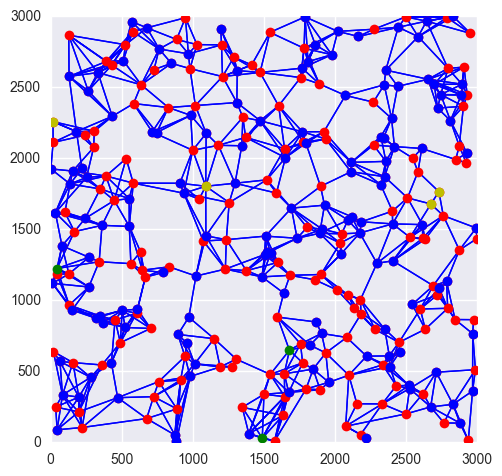

In [6]:
Data, n , subset=initNRandConn(300,4,10)
DataSaved1=Data.copy(deep=True)
Data=Vac(.5)
DataSaved2=Data.copy(deep=True)
Data=criticalPop(4)
DataSaved3=Data.copy(deep=True)
Data=initSick(3)
DataSaved4=Data.copy(deep=True)
plotIt2()

And can step through the progression of the disease through the community.

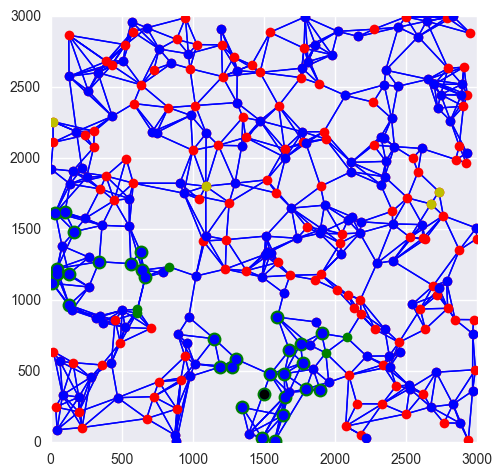

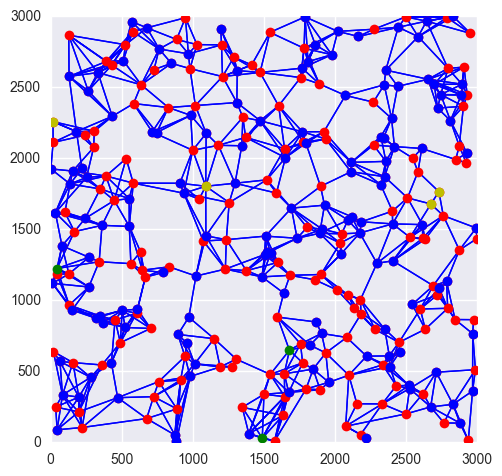

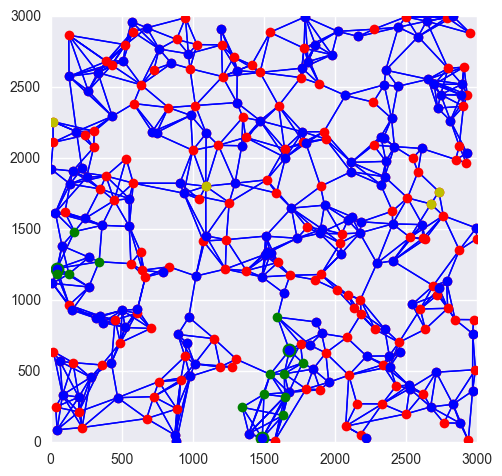

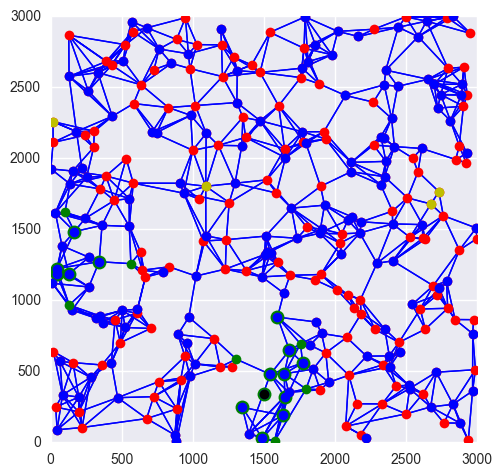

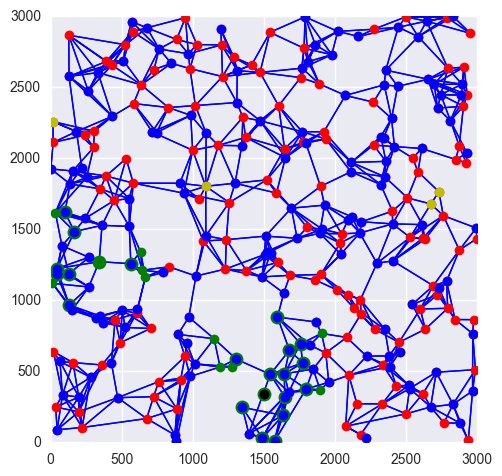

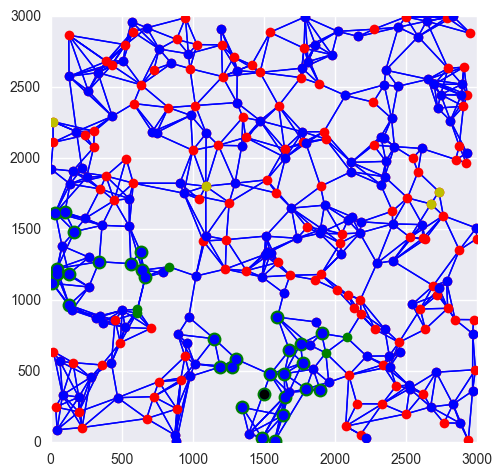

In [7]:
for i in range(5):
    #plt.gca().cla();
    plt.gcf()
    plotIt2()
    Data, l, temp=spreadAdv(.9, 1, .85, .02,.6); #IllPercent, RecPercent, vacEffectiveness,DeathRate, criticalRate
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #time.sleep(.1);